In [14]:
from __future__ import division
from scipy.integrate import odeint,ode
from numpy import zeros,ones,eye,tanh,dot,outer,sqrt,linspace,cos,pi,hstack
from numpy.random import uniform,normal,choice
import pylab as plt
import numpy as np
%matplotlib inline

## Exercise 1

Simulate the model:

$$\frac{d\mathbf{x}}{dt} = -\mathbf{x} + g J \tanh{[\mathbf{x}]} $$
with $x \in \mathcal{R}^N$ (vector), $J \in \mathcal{R}^{N \times N}$ (matrix), $g \in \mathcal{R}$ (scalar). Randomly draw each element of $J$ from a Gaussian distribution with zero mean and variance $1/N$. Characterize the output of the system for increasing values of $g$.

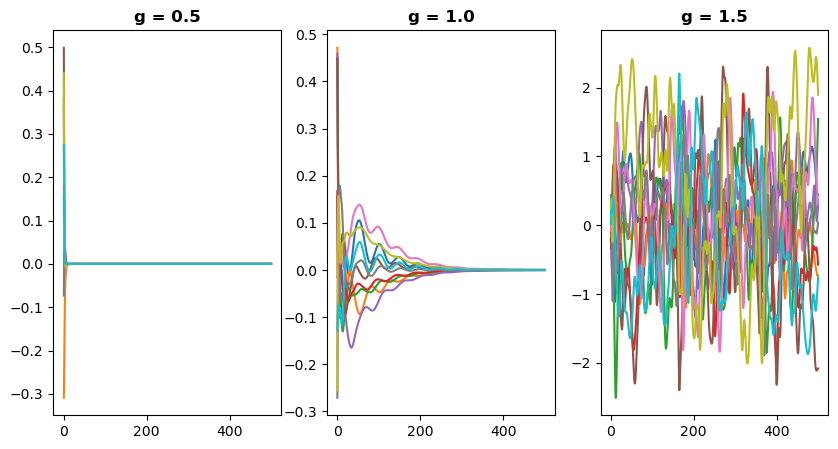

In [17]:
def f1(x,t0):
    return -x + g*dot(J,tanh(x))

N = 1000
J = normal(0,sqrt(1/N),(N,N))
x0 = uniform(-0.5,0.5,N)
t = linspace(0,500,5000)

plt.figure(figsize=(10,5))
for s,g in enumerate(linspace(0.5,1.5,3)):
    plt.subplot(1,3,s+1)
    x = odeint(f1,x0,t)
    plt.plot(t,x[:,choice(N,10)])
    plt.title('g = '+str(g),fontweight='bold')
plt.show()

In [16]:
J

array([[ 0.00217367,  0.05519023,  0.00980522, ...,  0.02347425,
        -0.00735299, -0.03667993],
       [ 0.00953739,  0.00826001,  0.03081067, ..., -0.03192701,
        -0.02092638,  0.00094083],
       [-0.02828282, -0.03451596, -0.02271739, ..., -0.01778804,
        -0.03084782, -0.02111485],
       ...,
       [ 0.01904205, -0.001489  ,  0.01356351, ..., -0.00221266,
         0.0642703 ,  0.03625107],
       [ 0.00114612,  0.0508723 ,  0.0013266 , ..., -0.07507861,
        -0.00325416,  0.03762252],
       [ 0.06213806,  0.02629706, -0.03724847, ..., -0.02135847,
         0.02497817,  0.00467738]])

## Exercise 2

Simulate the model with $g=1.5$ and a sinusoidal input:

$$\frac{d\mathbf{x}}{dt} = -\mathbf{x} + g J \tanh{[\mathbf{x}]} + A \cos (\omega t) \mathbf{u} $$
with $\mathbf{u} \in \mathcal{R}^N$ and each $u_i \in [-1,1]$. Vary the scalar parameters $A$ and $\omega$.

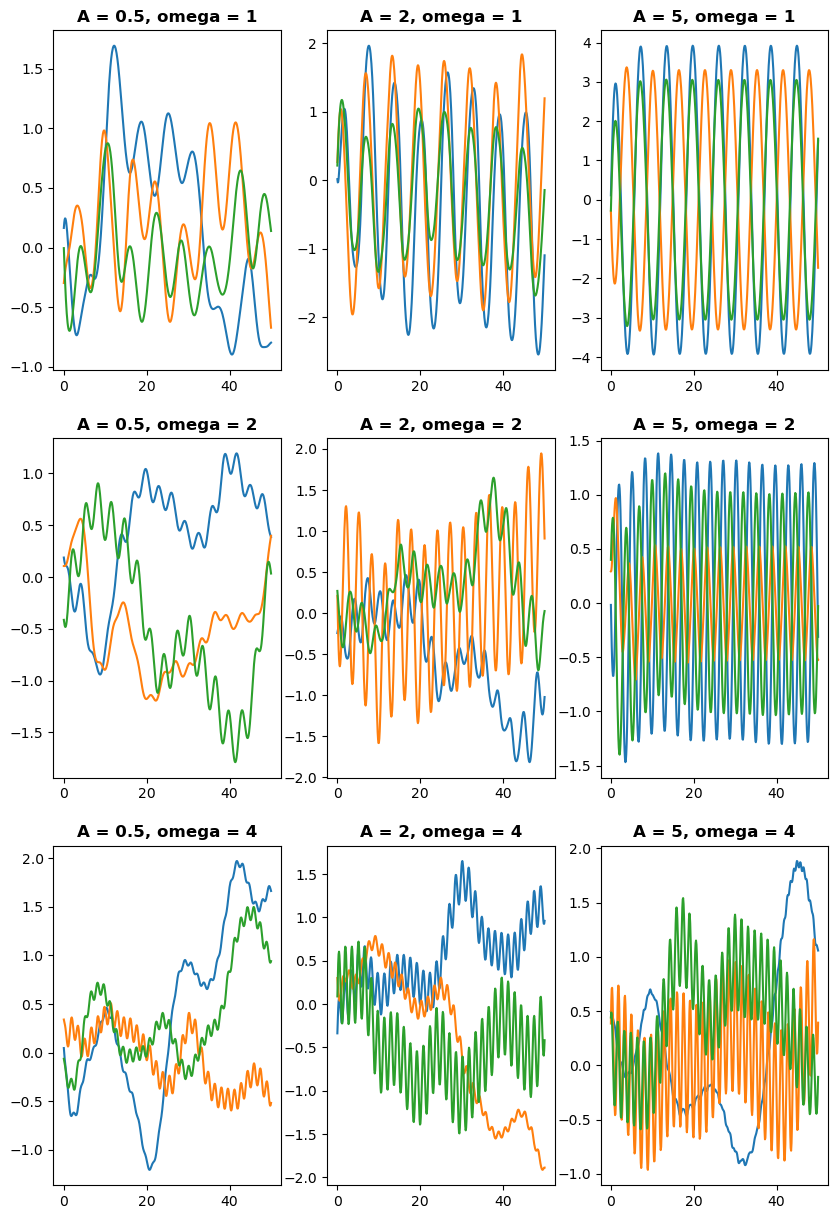

In [13]:
def f2(x,t0):
    return -x + g*dot(J,tanh(x)) + u*A*cos(o*t0)

plt.figure(figsize=(10,15))
g = 1.5
u = uniform(-1,1,N)
s = 1 # subplot index
for o in [1,2,4]:
    for A in [0.5,2,5]:
        plt.subplot(3,3,s)
        x = odeint(f2,x0,t)
        plt.plot(t,x[:,choice(N,3)])
        plt.title('A = '+str(A)+', omega = '+str(o),fontweight='bold')
        s += 1
plt.show()

## Exercise 3

Model an output or readout neuron for the network as:

$$z = \mathbf{w}^T \tanh[\mathbf{x}]$$
The output $z$ is a scalar formed by the dot product of two N-dimensional vectors ($\mathbf{w}^T$ denotes the transpose of $\mathbf{w}$). We will implement the FORCE learning rule (Susillo & Abbott, 2009), by adjusting the readout weights, $w_i$, so that $z$ matches a target function:

$$f(t) = \cos\left(\frac{2 \pi t}{50} \right)$$
The rule works by implementing recursive least-squares:

$$\mathbf{w} \rightarrow \mathbf{w} + c(f-z) \mathbf{q}$$

$$\mathbf{q} = P \tanh [\mathbf{x}]$$

$$c = \frac{1}{1+ \mathbf{q}^T \tanh(\mathbf{x})}$$

$$P_{ij} \rightarrow P_{ij} - c q_i q_j$$

In [4]:
target = lambda t0: cos(2*pi*t0/50) # target pattern

def f3(t0,x):
    return -x + g*dot(J,tanh_x) + dot(w,tanh_x)*u

dt = 1       # time step
tmax = 800   # simulation length
w = uniform(-1/sqrt(N),1/sqrt(N),N) # initial weights
P = eye(N) # Running estimate of the inverse correlation matrix
lr = 1.0 # learning rate

# simulation data: state, output, time, weight updates
x,z,t,wu = [x0],[],[0],[0]

# Set up ode solver
solver = ode(f3)
solver.set_initial_value(x0)

# Integrate ode, update weights, repeat
while t[-1] < tmax:
    tanh_x = tanh(x[-1]) # cache 
    z.append(dot(w,tanh_x))
    error = target(t[-1]) - z[-1]
    q = dot(P,tanh_x)
    c = lr / (1 + dot(q,tanh_x))
    P = P - c*outer(q,q)
    w = w + c*error*q
    
    if t[-1]>300: lr = 0
    
    wu.append(np.sum(np.abs(c*error*q)))
    
    solver.integrate(solver.t+dt)
    x.append(solver.y)
    t.append(solver.t)
    
# last update for readout neuron
z.append(dot(w,tanh_x))

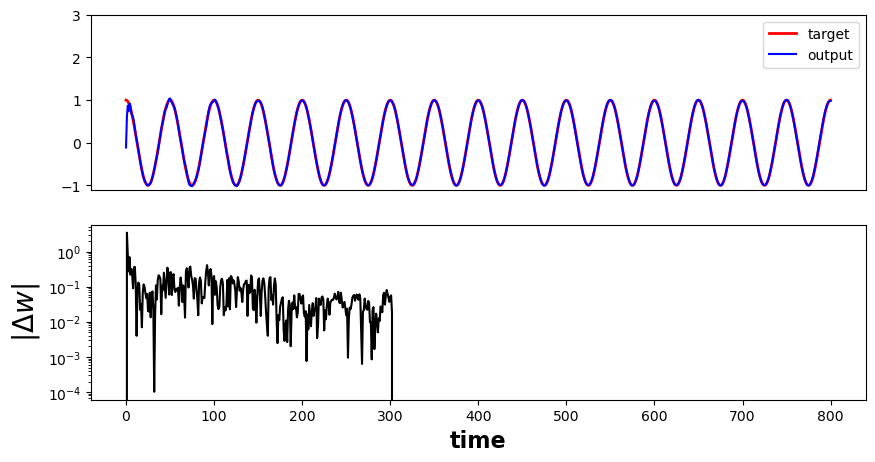

In [5]:
x = np.array(x)
t = np.array(t)

plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t,target(t),'-r',lw=2)
plt.plot(t,z,'-b')
plt.legend(('target','output'))
plt.ylim([-1.1,3])
plt.xticks([])
plt.subplot(2,1,2)
plt.plot(t,wu,'-k')
plt.yscale('log')
plt.ylabel('$|\Delta w|$',fontsize=20)
plt.xlabel('time',fontweight='bold',fontsize=16)
plt.show()